# Section 6: Forecasting and Practical Applications

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

## The Power of Probabilistic Forecasting

Traditional forecasting methods provide point estimates with confidence intervals based on strong assumptions. **Bayesian forecasting** offers several advantages:

### Key Benefits

1. **Full Uncertainty Quantification**: Complete probability distributions over future values
2. **Coherent Uncertainty Propagation**: Parameter uncertainty flows naturally into forecasts
3. **Flexible Prediction Intervals**: Any quantile or probability can be computed
4. **Decision-Theoretic Framework**: Optimal decisions under uncertainty

### Forecast Types

- **Point forecasts**: Expected values (posterior means)
- **Interval forecasts**: Credible intervals (e.g., 90% HDI)
- **Probabilistic forecasts**: Full predictive distributions
- **Scenario analysis**: Probability of specific events

In [5]:
# Import necessary libraries for Section 6
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import warnings

# Configure plotting and suppress warnings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
RANDOM_SEED = 42

print("🔧 Section 6 libraries loaded successfully!")
print("Ready to generate probabilistic forecasts!")

🔧 Section 6 libraries loaded successfully!
Ready to generate probabilistic forecasts!


## Data Preparation and Train-Test Split

For proper forecast evaluation, we need to split our data into training and testing sets.

In [6]:
# Load and prepare data with train-test split
births_data = pl.read_csv('../data/births.csv', null_values=['null', 'NA', '', 'NULL'])
births_data = births_data.filter(pl.col('day').is_not_null())

monthly_births = (births_data
    .group_by(['year', 'month'])
    .agg(pl.col('births').sum())
    .sort(['year', 'month'])
)

births_subset = (monthly_births
    .filter((pl.col('year') >= 1970) & (pl.col('year') <= 1990))
    .with_row_index('index')
)

# Standardize the data
original_data = births_subset['births'].to_numpy()
births_standardized = (original_data - original_data.mean()) / original_data.std()

# Train-test split (use last 24 months for testing)
n_forecast = 24
n_train = len(births_standardized) - n_forecast

y_train = births_standardized[:n_train]
y_test = births_standardized[n_train:]

print(f"📊 Data split:")
print(f"   Training: {len(y_train)} observations")
print(f"   Testing: {len(y_test)} observations")
print(f"   Forecast horizon: {n_forecast} months")

📊 Data split:
   Training: 204 observations
   Testing: 24 observations
   Forecast horizon: 24 months


## Building a Forecasting Model

Let's build a seasonal model that can generate forecasts with uncertainty quantification.

In [7]:
# Build a seasonal model for forecasting
time_idx_train = np.arange(len(y_train))
time_normalized_train = (time_idx_train - time_idx_train.mean()) / time_idx_train.std()

# Create seasonal components for training data
period = 12  # Monthly data with annual seasonality
seasonal_freq = 2 * np.pi / period
sin_seasonal_train = np.sin(seasonal_freq * time_idx_train)
cos_seasonal_train = np.cos(seasonal_freq * time_idx_train)

with pm.Model() as forecast_model:
    # Model parameters
    mu_overall = pm.Normal('mu_overall', mu=0, sigma=1)
    beta_trend = pm.Normal('beta_trend', mu=0, sigma=1)
    beta_sin = pm.Normal('beta_sin', mu=0, sigma=1)
    beta_cos = pm.Normal('beta_cos', mu=0, sigma=1)
    
    # Expected value for training data
    mu_train = pm.Deterministic('mu_train', 
                               mu_overall + 
                               beta_trend * time_normalized_train + 
                               beta_sin * sin_seasonal_train + 
                               beta_cos * cos_seasonal_train)
    
    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    
    # Likelihood (training data only)
    y_obs = pm.Normal('y_obs', mu=mu_train, sigma=sigma_obs, observed=y_train)

# Fit the model
with forecast_model:
    trace_forecast = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("✅ Forecasting model fitted successfully")
print(az.summary(trace_forecast, var_names=['mu_overall', 'beta_trend', 'beta_sin', 'beta_cos', 'sigma_obs']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_overall, beta_trend, beta_sin, beta_cos, sigma_obs]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Forecasting model fitted successfully
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_overall -0.134  0.052  -0.230   -0.039      0.001    0.001    2748.0   
beta_trend  0.441  0.052   0.348    0.545      0.001    0.001    2184.0   
beta_sin   -0.387  0.073  -0.525   -0.249      0.002    0.002    2178.0   
beta_cos   -0.426  0.074  -0.565   -0.291      0.001    0.002    3321.0   
sigma_obs   0.733  0.036   0.661    0.798      0.001    0.001    3443.0   

            ess_tail  r_hat  
mu_overall    1543.0    1.0  
beta_trend    1731.0    1.0  
beta_sin      1453.0    1.0  
beta_cos      1437.0    1.0  
sigma_obs     1413.0    1.0  


## Generating Probabilistic Forecasts

Now let's generate forecasts for the test period with full uncertainty quantification.

In [8]:
# Generate forecasts for the test period
time_idx_forecast = np.arange(len(y_train), len(y_train) + n_forecast)
time_normalized_forecast = (time_idx_forecast - time_idx_train.mean()) / time_idx_train.std()

# Create seasonal components for forecast period
sin_seasonal_forecast = np.sin(seasonal_freq * time_idx_forecast)
cos_seasonal_forecast = np.cos(seasonal_freq * time_idx_forecast)

# Extract posterior samples directly for manual forecasting
mu_overall_samples = trace_forecast.posterior['mu_overall'].values  # (chains, draws)
beta_trend_samples = trace_forecast.posterior['beta_trend'].values  # (chains, draws)
beta_sin_samples = trace_forecast.posterior['beta_sin'].values      # (chains, draws)
beta_cos_samples = trace_forecast.posterior['beta_cos'].values      # (chains, draws)
sigma_obs_samples = trace_forecast.posterior['sigma_obs'].values    # (chains, draws)

# Reshape to (n_samples,) for easier computation
n_chains, n_draws = mu_overall_samples.shape
mu_overall_flat = mu_overall_samples.flatten()
beta_trend_flat = beta_trend_samples.flatten()
beta_sin_flat = beta_sin_samples.flatten()
beta_cos_flat = beta_cos_samples.flatten()
sigma_obs_flat = sigma_obs_samples.flatten()

# Compute forecast means for each posterior sample
forecast_means = np.zeros((len(mu_overall_flat), n_forecast))
for i in range(len(mu_overall_flat)):
    forecast_means[i, :] = (mu_overall_flat[i] + 
                           beta_trend_flat[i] * time_normalized_forecast +
                           beta_sin_flat[i] * sin_seasonal_forecast +
                           beta_cos_flat[i] * cos_seasonal_forecast)

# Generate forecast samples including observation noise
np.random.seed(RANDOM_SEED)  # For reproducibility
forecast_samples_array = np.zeros((len(mu_overall_flat), n_forecast))
for i in range(len(mu_overall_flat)):
    forecast_samples_array[i, :] = np.random.normal(
        forecast_means[i, :], 
        sigma_obs_flat[i], 
        size=n_forecast
    )

print("🔮 Generated probabilistic forecasts for test period")

🔮 Generated probabilistic forecasts for test period


In [9]:
# Extract forecast statistics from manual computation
# Compute forecast statistics
forecast_mean = np.mean(forecast_samples_array, axis=0)
forecast_median = np.median(forecast_samples_array, axis=0)
forecast_hdi_90_lower = np.percentile(forecast_samples_array, 5, axis=0)
forecast_hdi_90_upper = np.percentile(forecast_samples_array, 95, axis=0)
forecast_hdi_50_lower = np.percentile(forecast_samples_array, 25, axis=0)
forecast_hdi_50_upper = np.percentile(forecast_samples_array, 75, axis=0)

print("📊 Forecast Statistics Computed:")
print(f"   Mean forecast: {forecast_mean[:5]} ... (first 5 values)")
print(f"   90% HDI width: {(forecast_hdi_90_upper - forecast_hdi_90_lower)[:5]} ... (first 5 values)")

📊 Forecast Statistics Computed:
   Mean forecast: [0.19767476 0.06956339 0.10612709 0.27795588 0.54416728] ... (first 5 values)
   90% HDI width: [2.46445319 2.35595515 2.53508477 2.43830962 2.47413297] ... (first 5 values)


## Forecast Visualization and Evaluation

Let's visualize our forecasts and evaluate their performance.

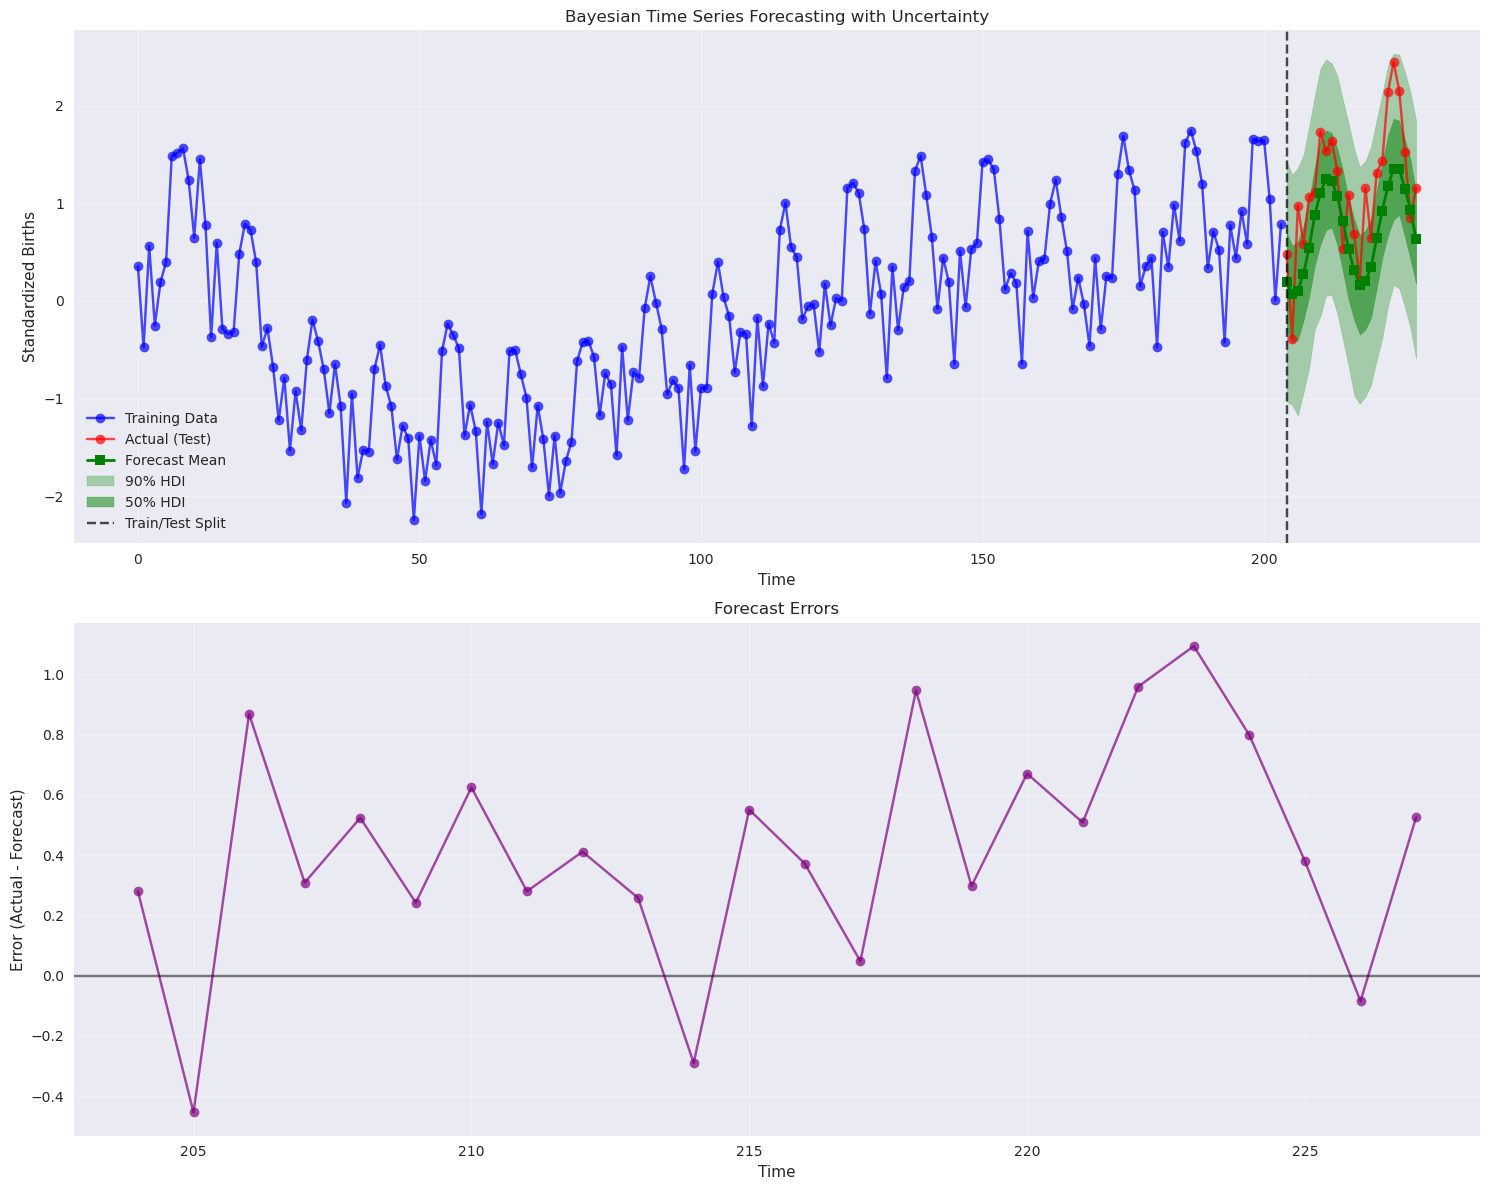


📈 **Forecast Evaluation Metrics**:
   Mean Absolute Error (MAE): 0.4905
   Root Mean Square Error (RMSE): 0.5617
   Mean Absolute Percentage Error (MAPE): 45.48%

🎯 **Coverage Analysis**:
   90% HDI Coverage: 100.0% (target: 90%)
   50% HDI Coverage: 54.2% (target: 50%)


In [10]:
# Create comprehensive forecast visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Full time series with forecasts
time_all = np.arange(len(births_standardized))
time_train = time_all[:n_train]
time_test = time_all[n_train:]

# Plot training data
ax1.plot(time_train, y_train, 'o-', color='blue', alpha=0.7, label='Training Data')

# Plot test data (actual)
ax1.plot(time_test, y_test, 'o-', color='red', alpha=0.7, label='Actual (Test)')

# Plot forecasts
ax1.plot(time_test, forecast_mean, 's-', color='green', linewidth=2, label='Forecast Mean')

# Plot uncertainty bands
ax1.fill_between(time_test, 
                forecast_hdi_90_lower, 
                forecast_hdi_90_upper, 
                alpha=0.3, color='green', label='90% HDI')

ax1.fill_between(time_test, 
                forecast_hdi_50_lower, 
                forecast_hdi_50_upper, 
                alpha=0.5, color='green', label='50% HDI')

ax1.axvline(n_train, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
ax1.set_title('Bayesian Time Series Forecasting with Uncertainty')
ax1.set_xlabel('Time')
ax1.set_ylabel('Standardized Births')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Forecast errors
forecast_errors = y_test - forecast_mean
ax2.plot(time_test, forecast_errors, 'o-', color='purple', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Forecast Errors')
ax2.set_xlabel('Time')
ax2.set_ylabel('Error (Actual - Forecast)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute forecast evaluation metrics
mae = np.mean(np.abs(forecast_errors))
rmse = np.sqrt(np.mean(forecast_errors**2))
mape = np.mean(np.abs(forecast_errors / y_test)) * 100

print(f"\n📈 **Forecast Evaluation Metrics**:")
print(f"   Mean Absolute Error (MAE): {mae:.4f}")
print(f"   Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"   Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Coverage analysis
in_90_hdi = ((y_test >= forecast_hdi_90_lower) & 
             (y_test <= forecast_hdi_90_upper))
coverage_90 = np.mean(in_90_hdi) * 100

in_50_hdi = ((y_test >= forecast_hdi_50_lower) & 
             (y_test <= forecast_hdi_50_upper))
coverage_50 = np.mean(in_50_hdi) * 100

print(f"\n🎯 **Coverage Analysis**:")
print(f"   90% HDI Coverage: {coverage_90:.1f}% (target: 90%)")
print(f"   50% HDI Coverage: {coverage_50:.1f}% (target: 50%)")

## Practical Applications and Decision Making

Bayesian forecasts enable sophisticated decision-making under uncertainty.

In [11]:
# Practical applications: Probabilistic decision making
print("🎯 **Practical Applications: Decision Making Under Uncertainty**")
print("="*70)

# Example 1: Probability of exceeding thresholds
threshold_high = 1.0  # High birth count threshold
threshold_low = -1.0  # Low birth count threshold

prob_exceed_high = np.mean(forecast_samples_array > threshold_high, axis=0)
prob_below_low = np.mean(forecast_samples_array < threshold_low, axis=0)

print(f"\n**Threshold Analysis**:")
print(f"   Probability of exceeding {threshold_high}: {prob_exceed_high[:6]} (first 6 months)")
print(f"   Probability of falling below {threshold_low}: {prob_below_low[:6]} (first 6 months)")

# Example 2: Risk assessment
risk_months = np.where(prob_exceed_high > 0.7)[0]
if len(risk_months) > 0:
    print(f"\n**Risk Assessment**:")
    print(f"   High-risk months (>70% chance of exceeding threshold): {risk_months + 1}")
else:
    print(f"\n**Risk Assessment**: No high-risk months identified")

# Example 3: Quantile forecasts for planning
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
forecast_quantiles = np.percentile(forecast_samples_array, [q*100 for q in quantiles], axis=0)

print(f"\n**Quantile Forecasts for Planning** (first 3 months):")
for i, q in enumerate(quantiles):
    values = forecast_quantiles[i, :3]
    print(f"   {q*100:4.0f}th percentile: {values}")

print(f"\n💡 **Business Applications**:")
print(f"   • **Capacity Planning**: Use 90th percentile for resource allocation")
print(f"   • **Risk Management**: Monitor probabilities of extreme events")
print(f"   • **Inventory Management**: Optimize stock levels using full distribution")
print(f"   • **Financial Planning**: Budget based on uncertainty ranges")

🎯 **Practical Applications: Decision Making Under Uncertainty**

**Threshold Analysis**:
   Probability of exceeding 1.0: [0.1485 0.1025 0.1255 0.158  0.2685 0.436 ] (first 6 months)
   Probability of falling below -1.0: [0.056  0.0635 0.0715 0.043  0.0225 0.005 ] (first 6 months)

**Risk Assessment**: No high-risk months identified

**Quantile Forecasts for Planning** (first 3 months):
     10th percentile: [-0.76994683 -0.87166815 -0.84295139]
     25th percentile: [-0.30806034 -0.4236109  -0.39947311]
     50th percentile: [0.19469336 0.05194557 0.10410741]
     75th percentile: [0.70225943 0.5633598  0.61013222]
     90th percentile: [1.18935028 1.01105316 1.09929215]

💡 **Business Applications**:
   • **Capacity Planning**: Use 90th percentile for resource allocation
   • **Risk Management**: Monitor probabilities of extreme events
   • **Inventory Management**: Optimize stock levels using full distribution
   • **Financial Planning**: Budget based on uncertainty ranges


## Best Practices for Bayesian Forecasting

### Model Selection and Validation
1. **Use proper scoring rules** (e.g., CRPS) for probabilistic forecast evaluation
2. **Implement rolling window validation** for robust performance assessment
3. **Check forecast calibration** - do 90% intervals contain 90% of observations?
4. **Monitor model performance** over time and retrain when necessary

### Communication and Interpretation
1. **Visualize uncertainty clearly** using fan charts or probability bands
2. **Provide multiple scenarios** (optimistic, realistic, pessimistic)
3. **Explain probabilistic language** to non-technical stakeholders
4. **Focus on decision-relevant metrics** rather than just point forecasts

### Technical Considerations
1. **Account for model uncertainty** through model averaging
2. **Handle structural breaks** with time-varying parameters
3. **Incorporate external information** through informative priors
4. **Scale computations** for high-frequency or multivariate data

## Summary and Next Steps

### What We've Accomplished

In this tutorial, we've covered:

1. **Section 1**: Motivation and time series fundamentals
2. **Section 2**: Bayesian inference and PyMC workflow
3. **Section 3**: Basic time series models (random walks, AR models)
4. **Section 4**: Advanced models (state-space, stochastic volatility, GPs)
5. **Section 5**: Model diagnostics and comparison
6. **Section 6**: Probabilistic forecasting and applications

### Key Takeaways

- **Bayesian methods provide natural uncertainty quantification** for time series
- **PyMC offers powerful tools** for building sophisticated time series models
- **Proper diagnostics are essential** for reliable inference
- **Probabilistic forecasts enable better decision-making** under uncertainty

### Further Learning

- **Advanced Topics**: Vector autoregressions, dynamic factor models, regime-switching models
- **Computational Methods**: Variational inference, particle filters, sequential Monte Carlo
- **Applications**: Finance, epidemiology, climate science, marketing mix modeling
- **Software**: Stan, TensorFlow Probability, Pyro for alternative implementations

---

**Thank you for joining this tutorial on Bayesian Time Series Analysis with PyMC!**

**Questions? Let's discuss!** 🚀